In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from PIL import Image

sns.set()

In [2]:
from typing import List, Tuple
import math

class SmartPlot:
    @staticmethod
    def plot_single_image(image,
                          title,
                          colorbar=False):
        plt.imshow(image)
        plt.title(title)
        if colorbar:
            plt.colorbar()
        plt.show()
    
    @staticmethod
    def get_dimensions(N):
        sqrt = round(math.sqrt(N))
        if sqrt * sqrt == N:
            return (sqrt, sqrt)
        for m in range(5, 0, -1):
            if N % m == 0:
                return (N//m, m)
    
    @classmethod
    def plot_multi_images(cls,
                          images: List,
                          figsize: Tuple[int, int],
                          titles: List | None = None,
                          axis: List | str = 'on',
                          cmaps: List | str = 'viridis',
                          suptitle: str | None = None,
                          dimensions: Tuple[int, int] | None = None,
                          colorbar: bool | List[bool] = False,
                          return_fig_axis: bool = False
                          ):
        num_images = len(images)
        if titles is None:
            titles = [None] * num_images
        if dimensions is None:
            dimensions = cls.get_dimensions(num_images)
        if type(colorbar) is bool:
            colorbar = [colorbar] * num_images
        if type(axis) is str:
            axis = [axis] * num_images
        if type(cmaps) is str:
            cmaps = [cmaps] * num_images

        fig, ax = plt.subplots(*dimensions, figsize=figsize)
        ax = np.array(ax).flatten()

        for i, (img, title, cbar) in enumerate(zip(images, titles, colorbar)):
            t = ax[i].imshow(img, cmap=cmaps[i])
            if title:
                ax[i].set_title(title)
            if cbar:
                plt.colorbar(t)
            ax[i].axis(axis[i])
        
        if suptitle:
            fig.suptitle(suptitle)
        if return_fig_axis:
            return fig, ax
        else:
            plt.show()


In [3]:
def convolution(img : np.ndarray, kernel : np.ndarray, stride : int = 1, mode=None, padding=True) -> np.ndarray:
    # kernel and image sizes
    kernel_size = kernel.shape
    img_size = img.shape

    # dimensions of image
    W, H = img_size[:2]
    # dimension of kernel
    k = kernel_size[0]
    assert kernel_size[0] == kernel_size[1], "kernel should be a k x k matrix"

    if padding:
        padding = k >> 1
    
    # flipped images
    horizontal_flipped = img[::-1]
    vertical_flipped = img[:,::-1]
    fully_flipped = img[::-1,::-1]

    # creating padded image
    if padding:
        padded_array = np.zeros((W+2*padding, H+2*padding))
        padded_array[padding:-padding,padding:-padding] = img.copy()
        if mode == 'reflect':
            padded_array[:padding,:padding] = fully_flipped[-padding:,-padding:]
            padded_array[-padding:,-padding:] = fully_flipped[:padding,:padding]
            padded_array[:padding,-padding:] = fully_flipped[-padding:,:padding]
            padded_array[-padding:,:padding] = fully_flipped[:padding,-padding:]
            padded_array[:padding,padding:-padding] = horizontal_flipped[-padding:,:]
            padded_array[-padding:,padding:-padding] = horizontal_flipped[:padding,:]
            padded_array[padding:-padding,:padding] = vertical_flipped[:,-padding:]
            padded_array[padding:-padding,-padding:] = vertical_flipped[:,:padding]
    else:
        padded_array = img.copy()
        
    output = np.zeros(( 1+(W+2*padding-k)//stride, 1+(H+2*padding-k)//stride ))
    x,y = 0,0
    for i in range(0, W+1+2*padding-k, stride):
        for j in range(0, H+1+2*padding-k, stride):
            output[x,y] = np.sum(padded_array[i:i+k,j:j+k]*kernel)
            y += 1
            
        x += 1
        y = 0
        
    return output

In [4]:
def gaussian_filter(sigma, filter_size):
    # we can write the gaussian filter as a gram matrix
    # this is because it can be separated as a function of
    # u and v
    vec = np.arange(-(filter_size-1)/2, (filter_size+1)/2)
    vec = np.exp(-0.5 * np.square(vec) / (sigma**2))

    filter = vec[:,None] @ vec[None,:]
    filter /= 2 * np.pi * np.square(sigma)
    filter /= filter.sum()
    return filter

# Question-1

In [5]:
class Image_quality_measures:
    @staticmethod
    def mse(image1: np.ndarray, image2: np.ndarray):
        return np.mean(np.square(image1-image2))
    
    @classmethod
    def psnr(cls, image1: np.ndarray, image2: np.ndarray):
        return 10 * np.log10(
            255*255 / (cls.mse(image1, image2)+1e-9)
            )
    
    @staticmethod
    def ssim(image1, image2):
        C1 = (2.55)**2
        C2 = 9 * C1
        C3 = C2 / 2
        filter_size = 5
        f = filter_size
        sigma = (filter_size - 1) / 6
        window = gaussian_filter(sigma=sigma,
                                 filter_size=filter_size)
        n, m = image1.shape
        dummy_image1 = np.zeros((n+f, m+f))
        dummy_image2 = np.zeros((n+f, m+f))
        dummy_image1[f//2: -f//2, f//2: -f//2] = image1
        dummy_image2[f//2: -f//2, f//2: -f//2] = image2
        image1 = dummy_image1
        image2 = dummy_image2


        def luminance_similarity(patch1, patch2):
            u1 = np.sum(patch1 * window)
            u2 = np.sum(patch2 * window)
            return (2*u1*u2 + C1) / (u1*u1 + u2*u2 + C1)
        
        def weighted_std(patch):
            arr = patch - patch.mean()
            arr = arr * arr * window
            return np.sqrt(arr.sum())

        def contrast_similarity(patch1, patch2):
            sig1 = weighted_std(patch1)
            sig2 = weighted_std(patch2)
            return (2*sig1*sig2 + C2) / (sig1*sig1 + sig2*sig2 + C2)
        
        def weighted_cross_covariance(patch1, patch2):
            arr1 = patch1 - patch1.mean()
            arr2 = patch2 - patch2.mean()
            return np.sum( window * arr1 * arr2 )

        def structure_similarity(patch1, patch2):
            sig1 = weighted_std(patch1)
            sig2 = weighted_std(patch2)
            sig12 = weighted_cross_covariance(patch1, patch2)
            return (sig12 + C3) / (sig1*sig1 + sig2*sig2 + C3 )

        def ssim(i, j):
            patch1 = image1[i-f//2: i+1+f//2, j-f//2:j+1+f//2]
            patch2 = image2[i-f//2: i+1+f//2, j-f//2:j+1+f//2]
            return (luminance_similarity(patch1, patch2) *
                    contrast_similarity(patch1, patch2) *
                    structure_similarity(patch1, patch2))
        ssim_map = np.array([[ssim(i, j) for j in range(f//2, image1.shape[1]-f//2-1)]
                             for i in range(f//2, image1.shape[0]-f//2-1)])
        return ssim_map, ssim_map.mean()


In [6]:
class distortions:
    @staticmethod
    def mean_shift(image, shift=16):
        return image+shift
    
    @staticmethod
    def awgn(image, sigma=16):
        return np.random.normal(loc=image, scale=sigma, size=image.shape)
    
    @staticmethod
    def jpeg(image):
        img = Image.fromarray(image).convert("L")
        buffer = BytesIO()
        img.save(buffer, 'JPEG', quality=10)
        buffer.seek(0)
        img = Image.open(BytesIO(buffer.read()))
        return img
    
    @staticmethod
    def gaussian_blur(image, sigma=2, filter_size=5):
        filter = gaussian_filter(sigma, filter_size)
        return convolution(image, filter)

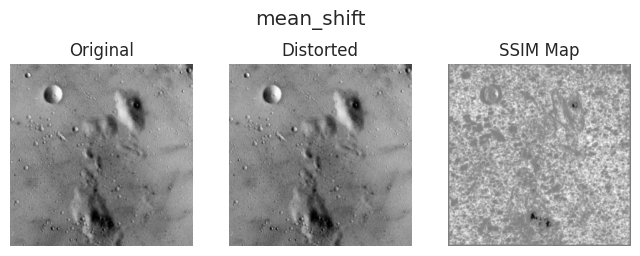

MSE: 256.0
PSNR: 24.048403955543645
SSIM: 0.6366443206394403
--------------------


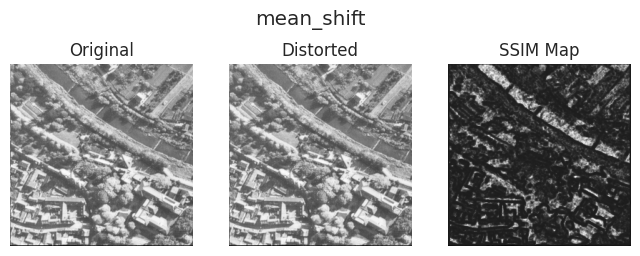

MSE: 256.0
PSNR: 24.048403955543645
SSIM: 0.5597245254653342
--------------------


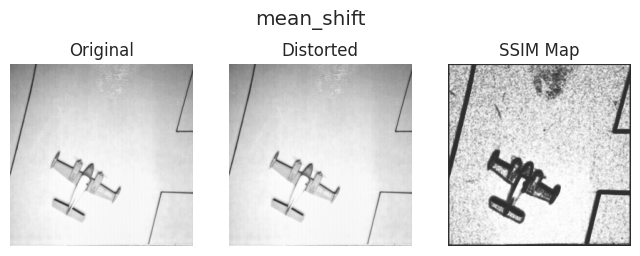

MSE: 256.0
PSNR: 24.048403955543645
SSIM: 0.8532447224162033
--------------------
xxxxxxxxxxxxxxxxxxxxxxxxx


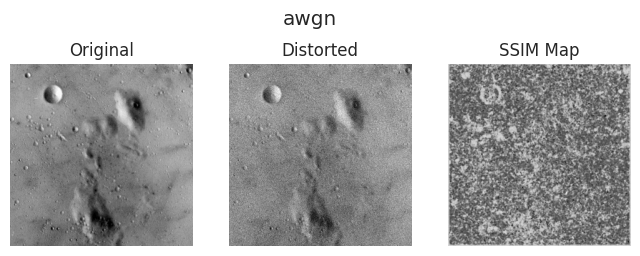

MSE: 254.7954782423448
PSNR: 24.06888644392152
SSIM: 0.19237829801108414
--------------------


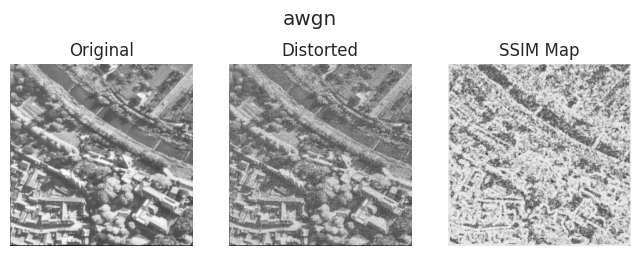

MSE: 255.54279609106698
PSNR: 24.05616718431524
SSIM: 0.31845025385729653
--------------------


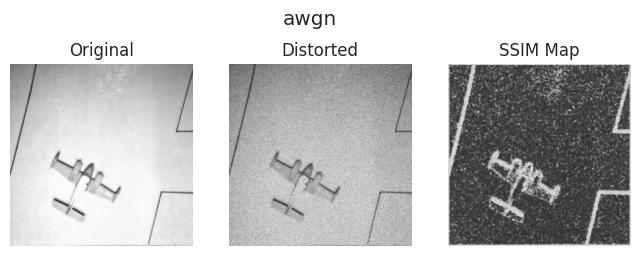

MSE: 255.78605417929708
PSNR: 24.05203498433042
SSIM: 0.11070143574355297
--------------------
xxxxxxxxxxxxxxxxxxxxxxxxx


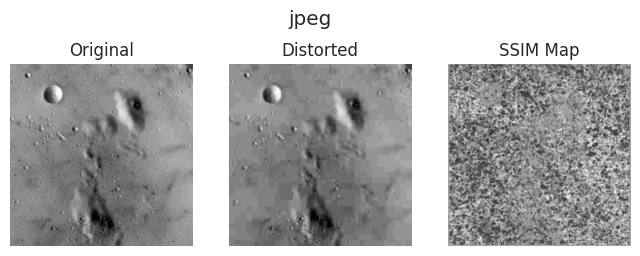

MSE: 86.947265625
PSNR: 28.738244322889543
SSIM: 0.37194196427474147
--------------------


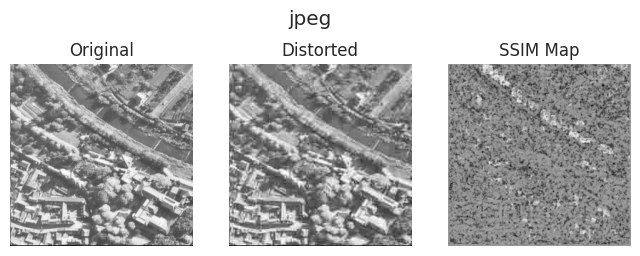

MSE: 212.7953338623047
PSNR: 24.851182602695076
SSIM: 0.35813560914075515
--------------------


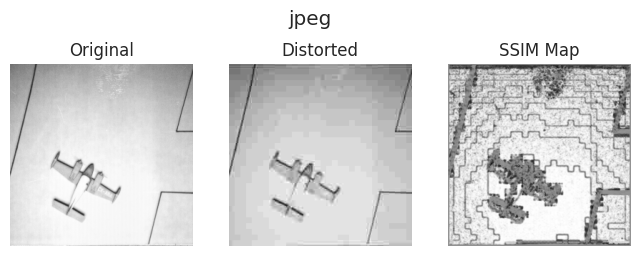

MSE: 45.61248779296875
PSNR: 31.539966007136265
SSIM: 0.7097138130449153
--------------------
xxxxxxxxxxxxxxxxxxxxxxxxx


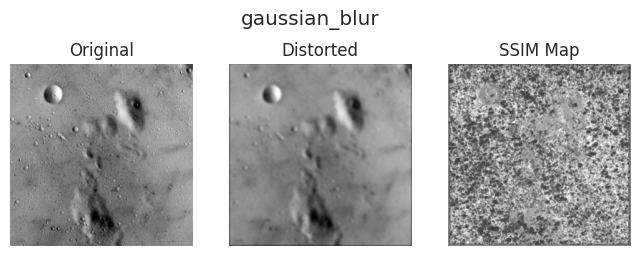

MSE: 120.27566661918453
PSNR: 27.32902588237267
SSIM: 0.3916206713104619
--------------------


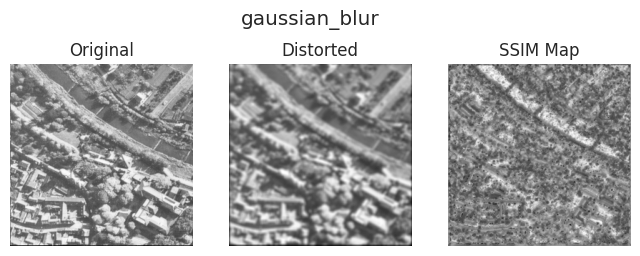

MSE: 340.39626538973937
PSNR: 22.810955742294237
SSIM: 0.30202300166011814
--------------------


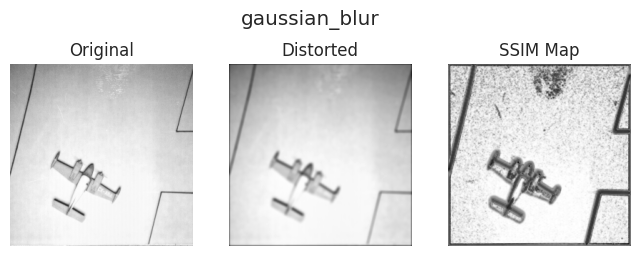

MSE: 134.0608909034253
PSNR: 26.857782596876447
SSIM: 0.7743660109156567
--------------------
xxxxxxxxxxxxxxxxxxxxxxxxx


In [7]:
image_paths = ['./misc/5.1.09.tiff',
               './misc/5.1.10.tiff',
               './misc/5.1.11.tiff']

images = [plt.imread(img_path).astype(float) for img_path in image_paths]

distortion_functions = [distortions.mean_shift,
                        distortions.awgn,
                        distortions.jpeg,
                        distortions.gaussian_blur]

psnrs = []
mses = []
ssims = []
for df in distortion_functions:
    for img in images:
        distorted = df(img)
        mse = Image_quality_measures.mse(img, distorted)
        psnr = Image_quality_measures().psnr(img, distorted)
        ssim_map, ssim = Image_quality_measures.ssim(img, distorted)
        
        psnrs.append(psnr); mses.append(mse); ssims.append(ssim)

        SmartPlot.plot_multi_images([img, distorted, ssim_map],
                  figsize=(8,3),
                  titles=['Original', 'Distorted', 'SSIM Map'],
                  suptitle=df.__name__,
                  cmaps='gray',
                  axis='off')
        print(f'MSE: {mse}')
        print(f'PSNR: {psnr}')
        print(f'SSIM: {ssim}')
        print('-'*20)
    print('x'*25)





In [8]:
my_scores = [
    0.95, 0.95, 0.95, 0.8, 0.7, 0.65, 0.75, 0.65, 0.5, 0.5, 0.5, 0.5
]
print(f'my scores: {my_scores}')

my scores: [0.95, 0.95, 0.95, 0.8, 0.7, 0.65, 0.75, 0.65, 0.5, 0.5, 0.5, 0.5]


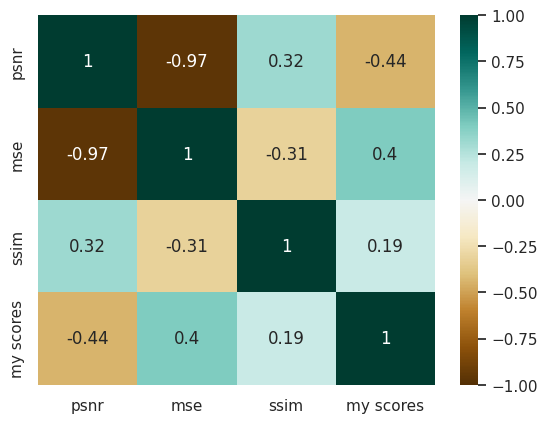

In [9]:
import pandas as pd
df = pd.DataFrame()
df['psnr'] = psnrs
df['mse'] = mses
df['ssim'] = ssims
df['my scores'] = my_scores

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

The correlation here is interesting. While it appears that mse is correlated more with my score, it actually means that the mse is higher when I give a higher score, that would immediately lead to issues when the noise levels are increased. SSIM on that other hand, even though it has a smaller correlation coefficient aligns with my scores.

# Question-2

## Subpart-1

In [10]:
def RGBA2L(image):
    img = image[:,:,:-1].mean(axis=-1)
    return img


lighthouse = RGBA2L(plt.imread('./lighthouse.png'))
template = RGBA2L(plt.imread('./template.png'))


In [11]:
class grad_edge:
    centered = (
        np.array([[0, 0, 0],
                    [-1, 0, 1],
                    [0, 0, 0]])/2,
        np.array([[0, -1, 0],
                    [0, 0, 0],
                    [0, 1, 0]])/2
    )
    robert = (
        np.array([[-1, 0], [0, 1]]),
        np.array([[0, -1], [1, 0]])
    )
    prewitt = (
        np.array([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]])/3,
        np.array([[-1, -1, -1],
                    [0, 0, 0],
                    [1, 1, 1]])/3
    )
    sobel = (
        np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])/4,
        np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])/4
    )
    
    @classmethod
    def centered_differencing(cls, image):
        return (convolution(image, filter) for filter in cls.centered)

    @classmethod
    def roberts_operator(cls, image):
        return (convolution(image, filter) for filter in cls.robert)
    
    @classmethod
    def prewitt_operator(cls, image):
        return (convolution(image, filter) for filter in cls.prewitt)
    
    @classmethod
    def sobel_operator(cls, image):
        return (convolution(image, filter) for filter in cls.sobel)


class grad_estimates:
    @staticmethod
    def l2(grad_map_x, grad_map_y):
        return np.sqrt(
            np.square(grad_map_x) +
            np.square(grad_map_y))
    
    @staticmethod
    def l1(grad_map_x, grad_map_y):
        return np.abs(grad_map_x) + np.abs(grad_map_y)
    
    @staticmethod
    def linf(grad_map_x, grad_map_y):
        return np.max(
                np.stack([
                np.abs(grad_map_x),
                np.abs(grad_map_y)], axis=-1),
            axis=-1)
    

def threshold_map(image, operator, magnitude_func):
    mapx, mapy = operator(image)
    mag = magnitude_func(mapx, mapy)
    # print(mag.max(), operator.__name__, magnitude_func.__name__)
    if magnitude_func.__name__ == 'l1':
        threshold = mag.max()/9
    elif magnitude_func.__name__ == 'l2':
        threshold = mag.max()/7
    else:
        threshold = mag.max()/6      
    return mag >= threshold



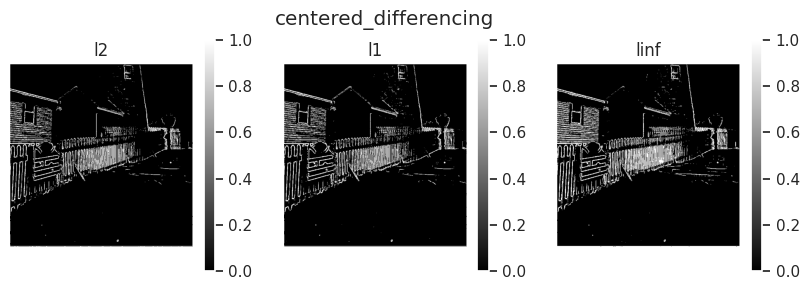

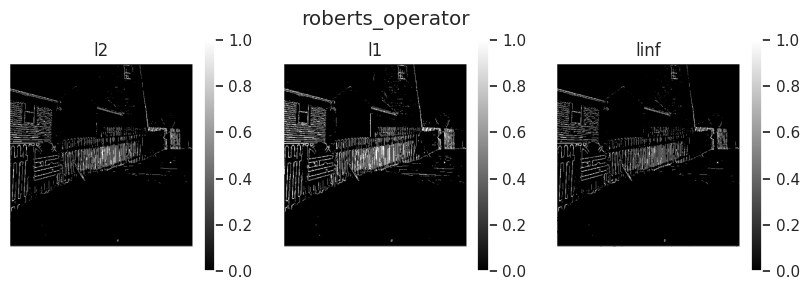

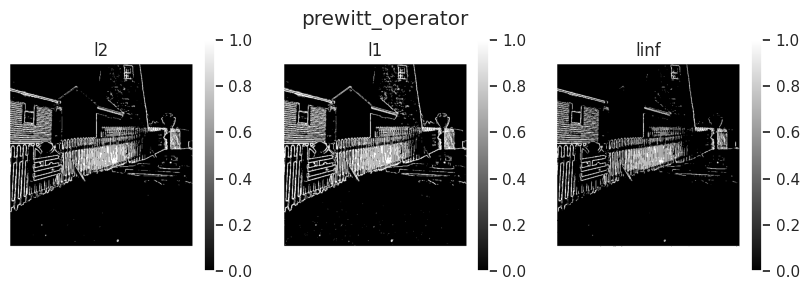

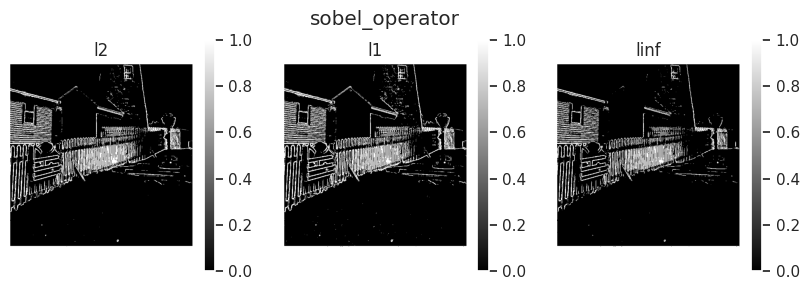

In [12]:
operators = [
    grad_edge().centered_differencing,
    grad_edge().roberts_operator,
    grad_edge().prewitt_operator,
    grad_edge().sobel_operator]

magnitude_functions = [
    grad_estimates.l2,
    grad_estimates.l1,
    grad_estimates.linf
]

for op in operators:
    maps2plot = []
    titles = []
    for magf in magnitude_functions:
        t = threshold_map(lighthouse, op, magf)
        maps2plot.append(t)
        titles.append(magf.__name__)

    SmartPlot.plot_multi_images(maps2plot,
                                titles=titles,
                                figsize=(10, 3),
                                axis='off',
                                cmaps='gray',
                                colorbar=True,
                                suptitle=op.__name__)
    plt.show()
        

I used the heuristic that threshold when l2 norm is 1/7 of the max magnitude, 1/6 for inf norm, 1/9 for l1 norm.

## Subpart-2

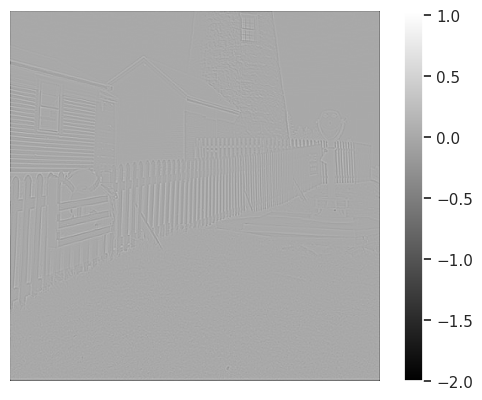

In [13]:
laplacian_filter = np.array([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
    ])

image = convolution(lighthouse, laplacian_filter)

plt.imshow(image, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()



In [14]:
def zero_crossing(image):
    n, m = image.shape
    output = np.zeros_like(image)
    for i in range(1, n-1):
        for j in range(1, m-1):
            patch = image[i-1: i+2, j-1: j+2]
            if patch.min() * patch.max() < 0:
                output[i, j] = 1
    return output


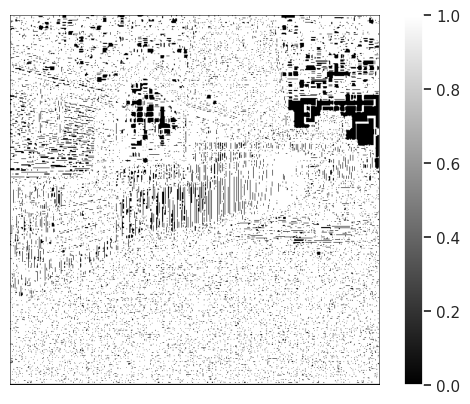

In [15]:
output = zero_crossing(image)

plt.imshow(output, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

## Subpart-3

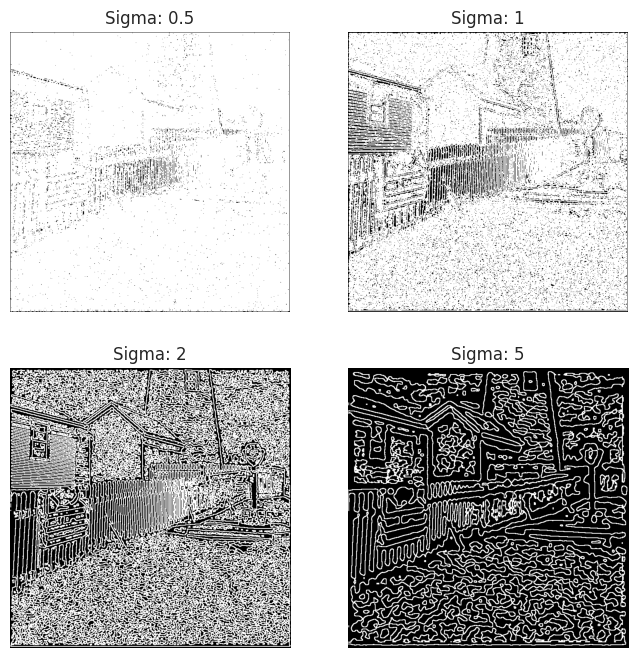

In [16]:
image = np.random.normal(loc=lighthouse, scale=10/255, size=lighthouse.shape)

images = []
titles = []
for sigma in [0.5, 1, 2, 5]:
    filter_size = int(6*sigma + 1)
    out_mid = convolution(image, gaussian_filter(sigma, filter_size))
    out = convolution(out_mid, laplacian_filter)
    out = zero_crossing(out)
    images.append(out)
    titles.append(f'Sigma: {sigma}')

SmartPlot.plot_multi_images(images, titles=titles, figsize=(8, 8), axis='off', cmaps='gray')



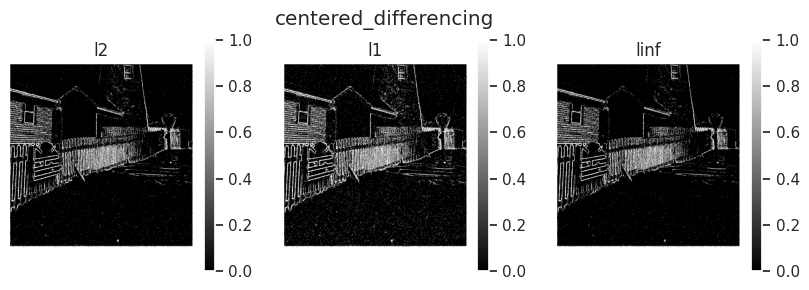

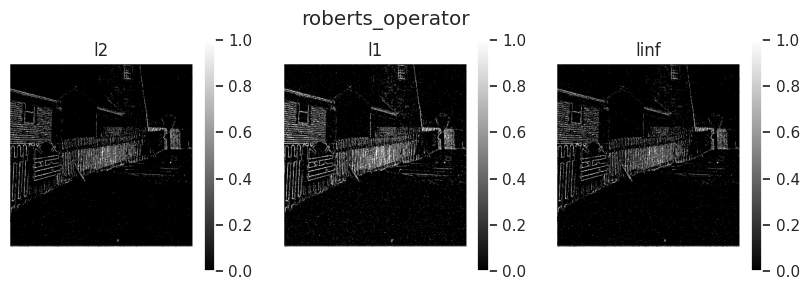

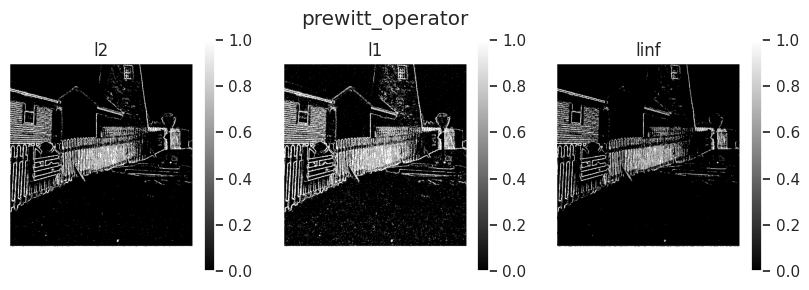

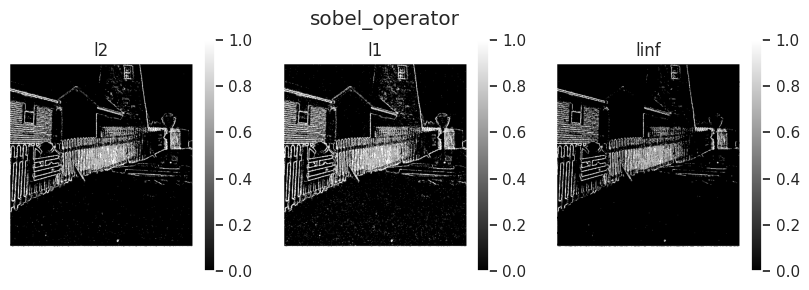

In [17]:

for op in operators:
    maps2plot = []
    titles = []
    for magf in magnitude_functions:
        t = threshold_map(image, op, magf)
        maps2plot.append(t)
        titles.append(magf.__name__)

    SmartPlot.plot_multi_images(maps2plot,
                                titles=titles,
                                figsize=(10, 3),
                                axis='off',
                                cmaps='gray',
                                colorbar=True,
                                suptitle=op.__name__)
    plt.show()

For my choice of threshold the gradient based edge detectors work good but that's the drawback, searching for an appropriate threshold.

# Question-3

## Subpart-1

In [18]:
def unpadded_conv(image, kernel):
    w, h = image.shape
    n, m = kernel.shape
    out = np.zeros((w-n+1, h-m+1))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i, j] = np.sum(image[i:i+n, j:j+m] * kernel)
    return out

In [19]:
def normalized_cross_correlation(image, template):
    mean_filter_scaled = np.ones_like(template)
    mean_conv = unpadded_conv(np.square(image), mean_filter_scaled)
    cross_conv = unpadded_conv(image, template)
    return cross_conv / np.sqrt(mean_conv * np.square(template).sum())

correlation_map = normalized_cross_correlation(lighthouse, template)

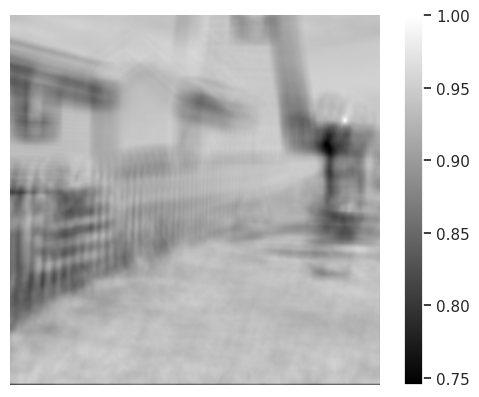

In [20]:
plt.imshow(correlation_map, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

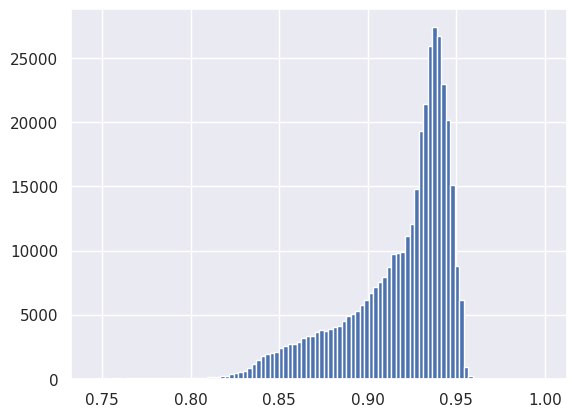

In [21]:
plt.hist(correlation_map.flatten(), bins=100)
plt.show()

A threshold value greater than 0.96 seems fine because there are very few pixels that satisfy that

## Subpart-2

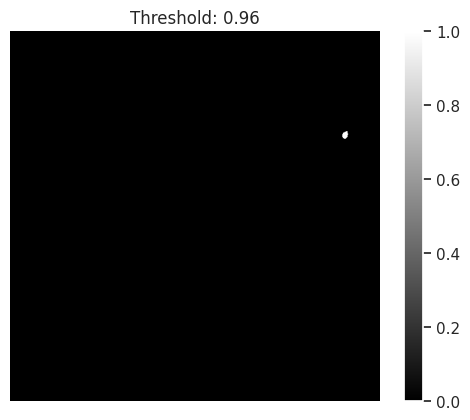

In [22]:
threshold = 0.96
plt.imshow(correlation_map>=threshold, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.title(f'Threshold: {threshold}')
plt.show()

## Subpart-3

0.9999378366119949


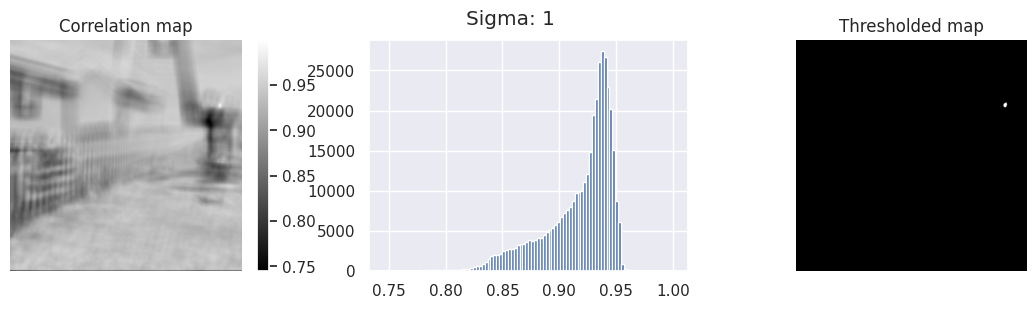

0.9994083432006986


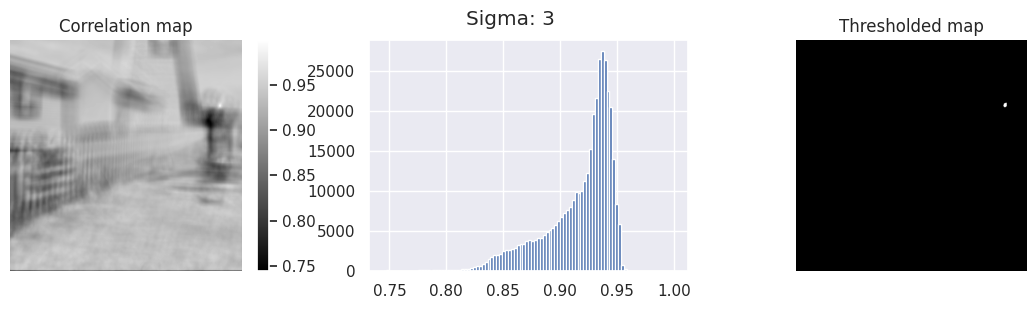

0.9978042392637271


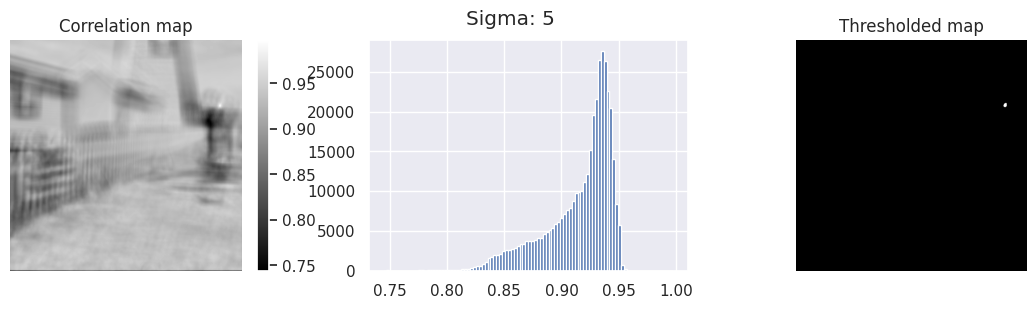

0.9918526970495138


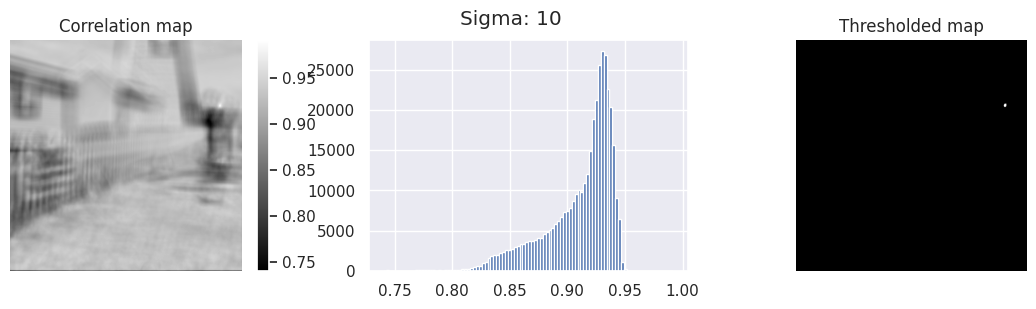

In [23]:
thresholds = [0.96, 0.96, 0.96, 0.96]
for sigma, th in zip([1, 3, 5, 10], thresholds):
    template = np.random.normal(loc=template, scale=sigma/255, size=template.shape)
    correlation_map = normalized_cross_correlation(lighthouse, template)
    fig, ax = plt.subplots(1, 3, figsize=(14, 3))
    t = ax[0].imshow(correlation_map, cmap='gray')
    plt.colorbar(t)
    ax[1].hist(correlation_map.flatten(), bins=100)
    ax[2].imshow(correlation_map>=th, cmap='gray')
    ax[0].set_title('Correlation map')
    ax[2].set_title('Thresholded map')
    fig.suptitle(f'Sigma: {sigma}')
    ax[0].axis('off')
    ax[2].axis('off')
    print(correlation_map.max())
    plt.show()


The choice of threshold isn't affected much by the AWGN because the highest correlation value is much above the choice of threshold. I've printed the highest correlation values.

## Subpart-4

0.9849046011515064


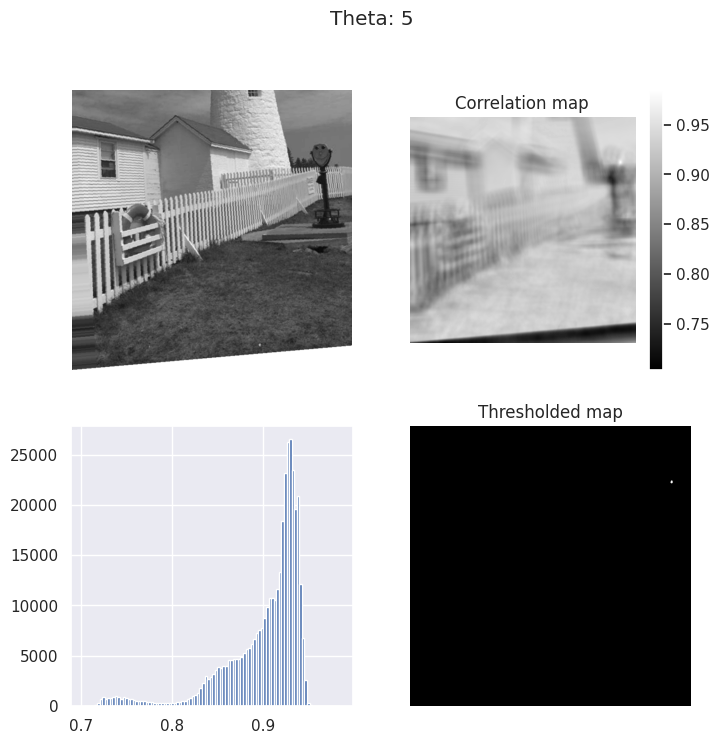

0.9751893488705605


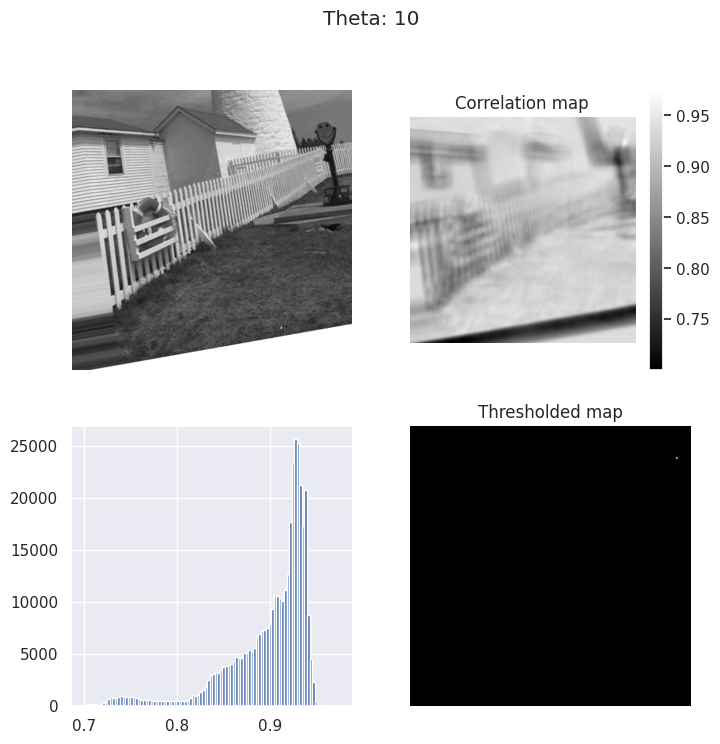

0.9657498643959055


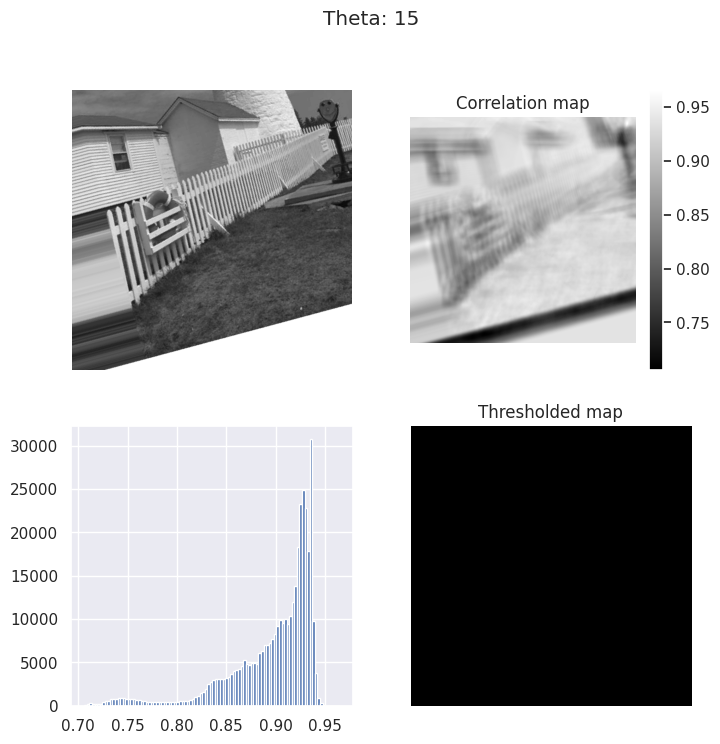

In [24]:
def rotation_matrix(theta):
    radians = np.pi * theta / 180
    matrix = np.array([
        [np.cos(radians), np.sin(radians), 0],
        [-np.sin(radians), np.cos(radians), 0],
        [0, 0, 1]
    ])
    return matrix

def rotate(image, theta):
    matrix = rotation_matrix(theta)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x, y, _ = matrix @ np.array([i, j, 1])
            x1, y1 = np.round(x).astype(int), np.round(y).astype(int)
            x1 = max(x1, 0)
            x1 = min(x1, image.shape[0]-1)
            y1 = max(y1, 0)
            y1 = min(y1, image.shape[1]-1)
            output[i, j] = image[x1, y1]
    return output




thresholds = [0.97, 0.97, 0.97]
for theta, th in zip([5, 10, 15], thresholds):
    img = rotate(lighthouse, theta)
    correlation_map = normalized_cross_correlation(img, template)
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax = np.array(ax).flatten()
    ax[0].imshow(img, cmap='gray')
    ax[0].axis('off')
    t = ax[1].imshow(correlation_map, cmap='gray')
    plt.colorbar(t)
    ax[2].hist(correlation_map.flatten(), bins=100)
    ax[3].imshow(correlation_map>=th, cmap='gray')
    ax[1].set_title('Correlation map')
    ax[3].set_title('Thresholded map')
    fig.suptitle(f'Theta: {theta}')
    ax[1].axis('off')
    ax[3].axis('off')
    print(correlation_map.max())
    plt.show()


I used a threshold of 0.97 although any threshold >= 0.97 works. The aforementioned threshold works for all the above images.